In [35]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import re
from datetime import datetime
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pylab import rcParams
import calendar

In [2]:
# Read data
df = pd.read_csv('train_1.csv/train_1.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [3]:
df = df.fillna(0)

In [4]:
df_reshaped = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Views')
df_reshaped.head()

,Page,Date,Views
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


In [5]:
df_reshaped['Date'] = pd.to_datetime(df_reshaped['Date']) 
df_reshaped = df_reshaped.set_index('Date')

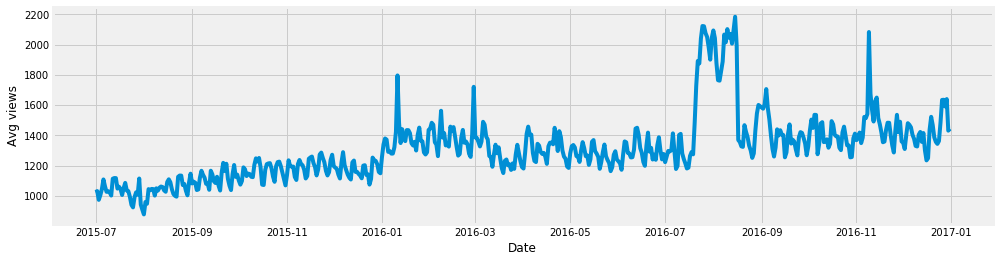

In [6]:
temp = df_reshaped.groupby('Date')['Views'].mean()
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Avg views')
plt.plot(temp)

In [ ]:
month_index = df_reshaped.index.month
views_by_month = df_reshaped.groupby(month_index).mean()
months=['January','Feb','March','April','May','June','July','August','September','October','November','December']

ax = views_by_month.plot()
start, end = ax.get_xlim()
plt.xticks(np.arange(start+0.5, end+0.5, 1.0))
ax.set_xticklabels(months,rotation=75)
ax.set_xlabel('Month')
ax.set_ylabel('Average views')
plt.show()

In [ ]:
weekday_index = df_reshaped.index.weekday_name
views_by_weekdays = df_reshaped.groupby(weekday_index).sum()
#months=['January','Feb','March','April','May','June','July','August','September','October','November','December']

ax = views_by_weekdays.plot()
#start, end = ax.get_xlim()
#plt.xticks(np.arange(start+0.5, end+0.5, 1.0))
#ax.set_xticklabels(months,rotation=75)
#ax.set_xlabel('Month')
ax.set_ylabel('Total views')
plt.show()

In [ ]:
def detect_lang(page):
    text = page.split('.wikipedia')
    if re.search('[a-z][a-z]',text[0][-2:]):
        return text[0][-2:]
    else: 
        return 'none'
    
df_reshaped['Page_language'] = df_reshaped.Page.apply(detect_lang)

def lang_code(code):
    if code == 'zh':
        return 'Chinese'
    elif code == 'fr':
        return 'French'
    elif code == 'en':
        return 'English'
    elif code == 'ru':
        return 'Russian'
    elif code == 'de':
        return 'German'
    elif code == 'ja':
        return 'Japanese'
    elif code == 'es':
        return 'Spanish'
    else:
        return 'None'
    
df_reshaped['Page_language'] = df_reshaped.Page_language.apply(lang_code)

In [ ]:
fig,ax = plt.subplots(figsize=(15,6))
lang_df = df_reshaped.groupby('Page_language')['Views'].sum().reset_index()
lang_df = lang_df[lang_df['Page_language']!='None']
lang_df['Views'] = round(lang_df['Views']/1000000,0)

bar_graph = lang_df.plot.bar(x='Page_language',y='Views',rot=30,ax=ax)
bar_graph.set_ylabel('Total views (in millions)')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_height()+500))
ax.legend()
plt.show()

In [ ]:
df_reshaped['Dayofweek'] = df_reshaped.Date.dt.dayofweek

def find_day(day):
    if day == 0:
        return 'Monday'
    elif day == 1:
        return 'Tuesday'
    elif day == 2:
        return 'Wednesday'
    elif day == 3:
        return 'Thursday'
    elif day == 4:
        return 'Friday'
    elif day == 5:
        return 'Saturday'
    else:
        return 'Sunday'
    
df_reshaped['Dayofweek'] = df_reshaped.Dayofweek.apply(find_day)

In [ ]:
day = df_reshaped.groupby('Dayofweek')['Views'].sum()
plt.figure(figsize=(15,4))
plt.xlabel('Day of week')
plt.ylabel('Total views')
plt.plot(day)
plt.show()

In [7]:
top_pages = df_reshaped.groupby('Page')['Views'].sum().reset_index()
top_pages.nlargest(5,'Views')

,Page,Views
58761,Main_Page_en.wikipedia.org_all-access_all-agents,1.206618e+10
58763,Main_Page_en.wikipedia.org_desktop_all-agents,8.774497e+09
58764,Main_Page_en.wikipedia.org_mobile-web_all-agents,3.153985e+09
93891,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,1.603934e+09
82337,Special:Search_en.wikipedia.org_all-access_all...,1.304079e+09


In [8]:
top5_pages_df = df_reshaped[df_reshaped['Page'].isin(['Main_Page_en.wikipedia.org_all-access_all-agents','Main_Page_en.wikipedia.org_desktop_all-agents','Main_Page_en.wikipedia.org_mobile-web_all-agents','Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents','Special:Search_en.wikipedia.org_all-access_all-agents'])]

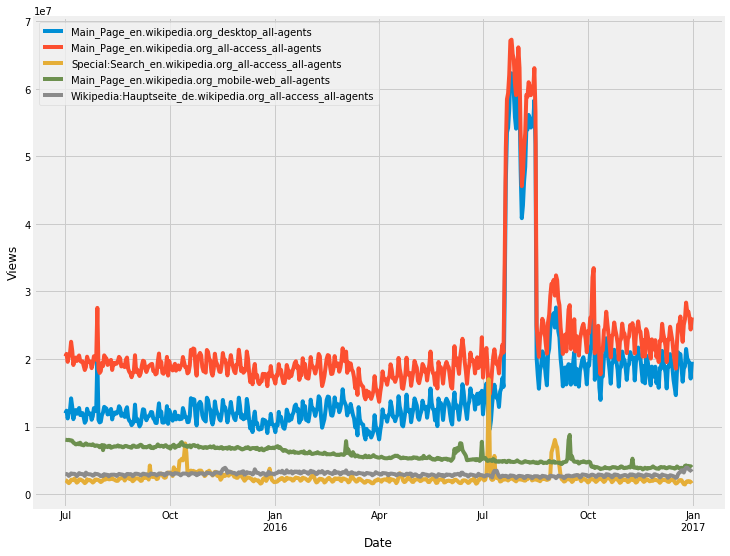

In [25]:
for i in list(top5_pages_df.Page.unique())[:5]:
    ax = top5_pages_df.loc[top5_pages_df.Page == i,:].Views.plot(label=i)
ax.set_ylabel('Views')
plt.legend(loc='upper left')
plt.show()

In [10]:
table = pd.pivot_table(top5_pages_df,values='Views',index=['Date'],columns=['Page'])

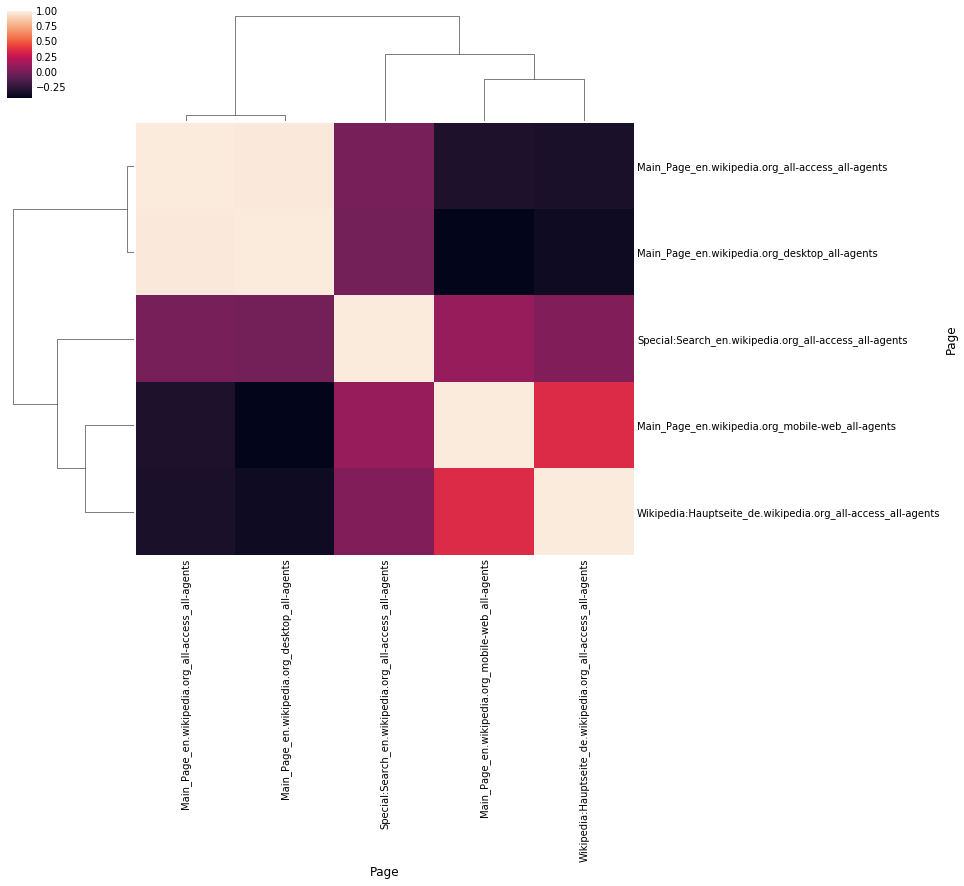

In [11]:
corr_matrix = table.corr(method='pearson')
sns.clustermap(corr_matrix)

In [12]:
top_page_df = df_reshaped[df_reshaped.Page == 'Main_Page_en.wikipedia.org_all-access_all-agents']
top_page_df.head()

,Page,Views
Date,,
2015-07-01,Main_Page_en.wikipedia.org_all-access_all-agents,20381245.0
2015-07-02,Main_Page_en.wikipedia.org_all-access_all-agents,20752194.0
2015-07-03,Main_Page_en.wikipedia.org_all-access_all-agents,19573967.0
2015-07-04,Main_Page_en.wikipedia.org_all-access_all-agents,20439645.0
2015-07-05,Main_Page_en.wikipedia.org_all-access_all-agents,20772109.0


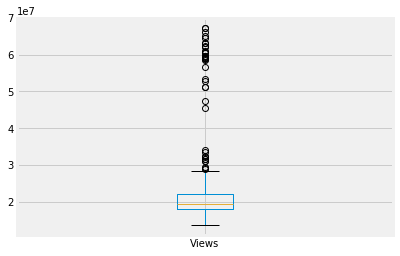

In [13]:
ax1 = top_page_df.boxplot()

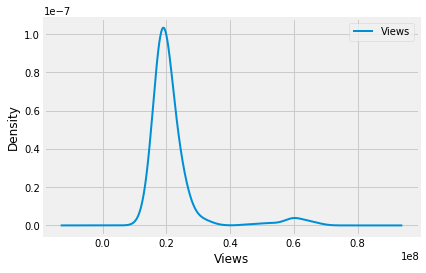

In [14]:
ax2 = top_page_df.plot(kind='density', linewidth=2)
ax2.set_xlabel('Views')
plt.show()

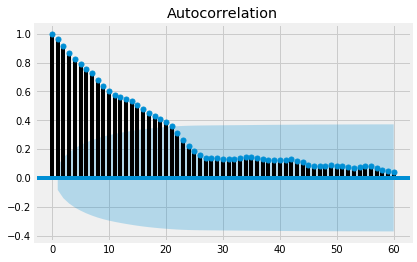

In [15]:
fig = tsaplots.plot_acf(top_page_df['Views'], lags=60)
plt.show()

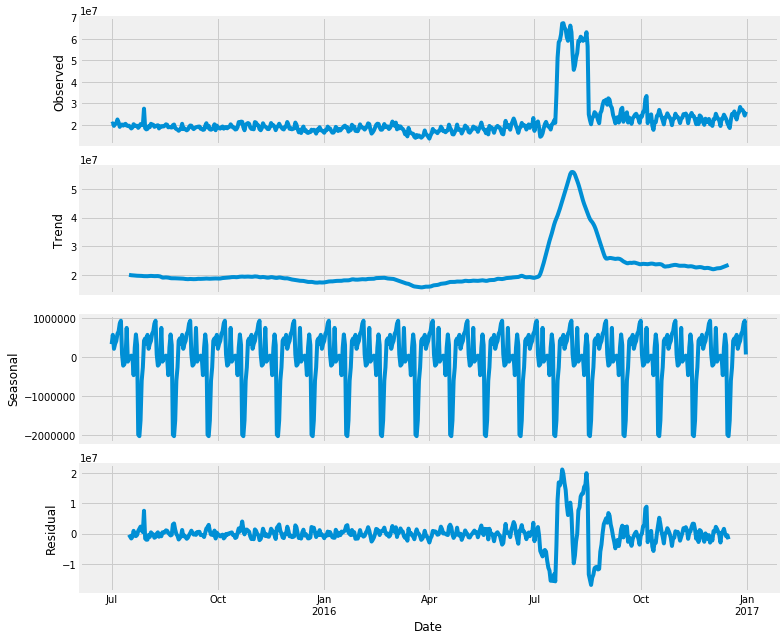

In [16]:
rcParams['figure.figsize'] = 11,9
ts_decomposition = sm.tsa.seasonal_decompose(top_page_df['Views'],freq = 30)
figure = ts_decomposition.plot()
plt.show()

## Augmented Dicky-Fuller test

In [17]:
test = adfuller(top_page_df['Views'])
print(test)

(-2.9901447422616267, 0.03582506369610538, 15, 534, {'1%': -3.4426552678216003, '5%': -2.8669676577777548, '10%': -2.569660749624767}, 17078.891523280352)


 0th element is the test statistic. Since the value is approximately -3, we can say that the data is more likely to be stationary.
 1st element indicates the p-value. Since the p-value is < 0.05, we can reject null hypothesis.

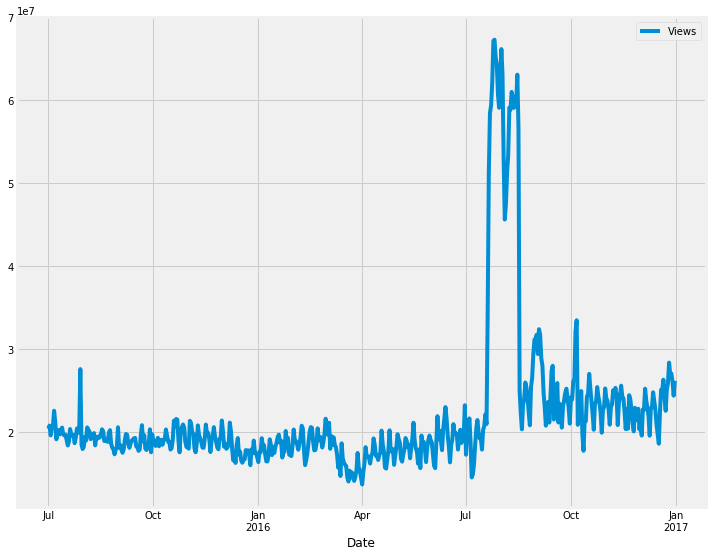

In [18]:
ax = top_page_df.plot()
plt.show()

In [19]:
top_page_filtered = top_page_df[['Views']]
stationary_df = top_page_filtered.diff().dropna()
stationary_df.head()

,Views
Date,
2015-07-02,370949.0
2015-07-03,-1178227.0
2015-07-04,865678.0
2015-07-05,332464.0
2015-07-06,1772560.0


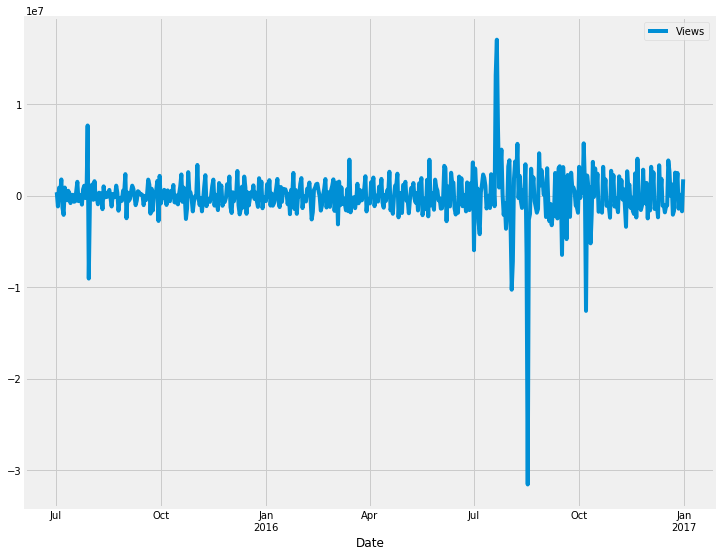

In [20]:
ax = stationary_df.plot()
plt.show()

In [21]:
test2 = adfuller(stationary_df['Views'])
print(test2)

(-6.6386055495935885, 5.481911439181468e-09, 14, 534, {'1%': -3.4426552678216003, '5%': -2.8669676577777548, '10%': -2.569660749624767}, 17054.780239373413)


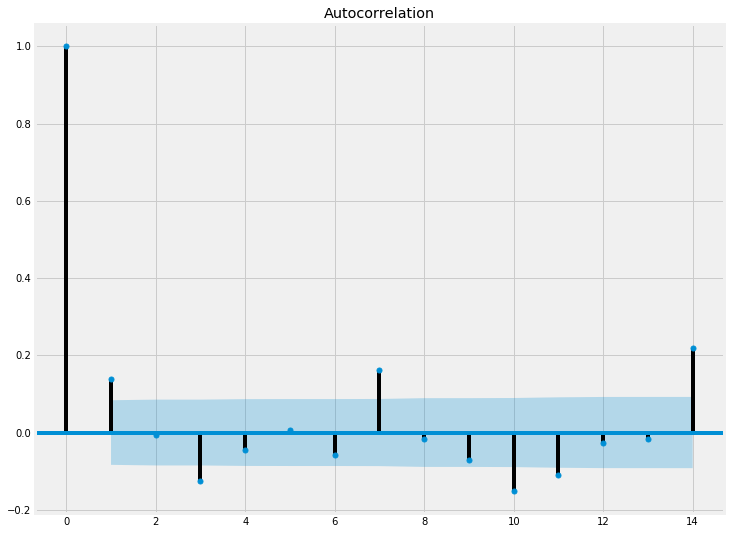

In [22]:
fig = tsaplots.plot_acf(stationary_df['Views'], lags=14)
plt.show()

## Modelling

In [29]:
train = top_page_filtered[:'2016-09']
test = top_page_filtered['2016-10':]

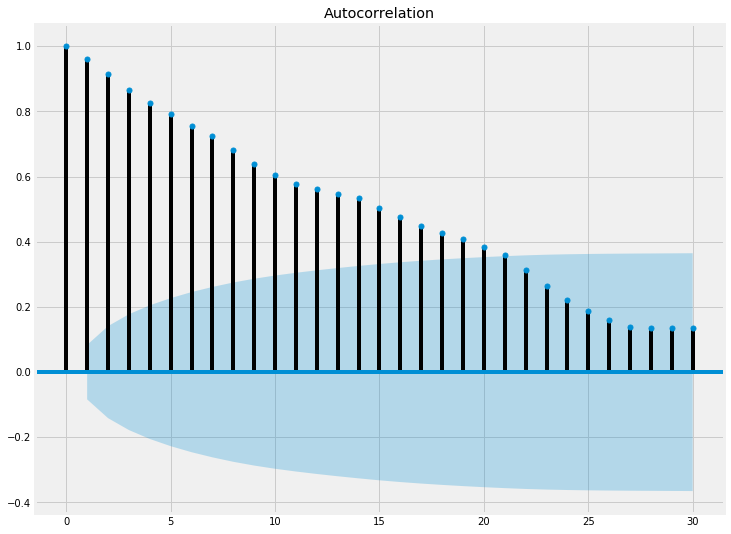

In [33]:
fig = tsaplots.plot_acf(top_page_filtered['Views'], lags=30)
plt.show()

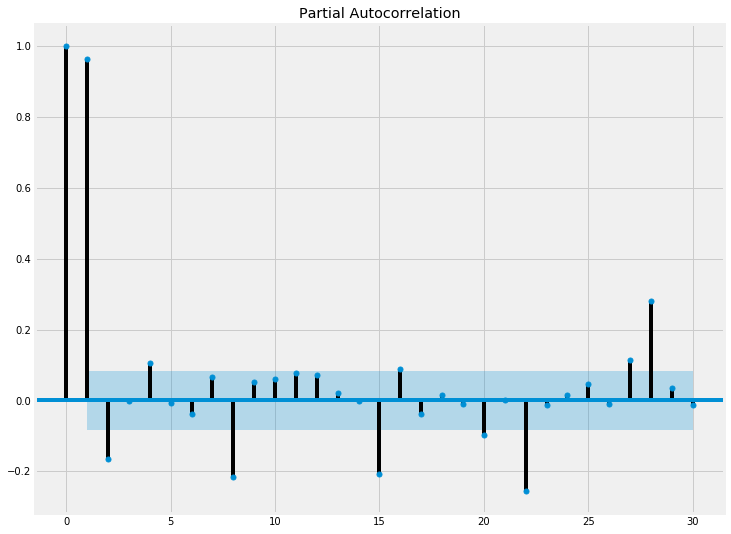

In [34]:
fig = tsaplots.plot_pacf(top_page_filtered['Views'], lags=30)
plt.show()

In [39]:
aic_bic_values = []
for p in range(7):
    for q in range(7):
        try:
            model = SARIMAX(top_page_filtered, order=(p,0,q))
            result = model.fit()
            aic_bic_values.append((p,q,result.aic,result.bic))
            print(p, q, result.aic, result.bic)
        except:
            print(p,q,None,None)


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.

0 0 20243.62662447743 20247.93654275566
0 1 None None
0 2 None None
0 3 None None
0 4 None None
0 5 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq,

0 6 19708.063428392015 19738.2328563396
1 0 17770.72243240993 17779.342268966382


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


1 1 17761.875298730414 17774.805053565095
1 2 17763.344462309455 17780.58413542236
1 3 17755.91498814749 17777.464579538624


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


1 4 17757.93757044941 17783.79708011877


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


1 5 17759.409526205993 17789.578954153578
1

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


 6 17753.804996008155 17788.28434223397
2 0 17761.781433754903 17774.711188589583


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2 1 17763.675847918705 17780.91552103161
2 2 17763.56949436329 17785.119085754424
2 3 17758.34043911758 17784.19994878694


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2 4 17754.884615940093 17785.054043887678


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2 5 17754.42622780858 17788.905574034394


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2 6 17752.427604639528 17791.216869143565
3 0 17763.515378697248 17780.755051810153


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


3 1 17765.625162019518 17787.17475341065


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


3 2 17736.551404090675 17762.410913760035


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


3 3 17760.459880724382 17790.629308671967


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


3 4 17726.22292006995 17760.702266295764


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


3 5 17737.6032358071 17776.392500311136


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


3 6 17752.75773297199 17795.856915754255
4 0 17757.602942646925 17779.152534038058
4 1 17759.55360009787 17785.41310976723


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


4 2 17761.567054185987 17791.736482133572


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


4 3 17752.105930678008 17786.58527690382


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


4 4 17704.664748153788 17743.454012657825


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


4 5 17712.408128852832 17755.507311635098


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


4 6 17751.943278624676 17799.35237968517
5 0 17759.55795895707 17785.41746862643
5 1 17756.968089810598 17787.137517758183


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


5 2 17714.807001013192 17749.286347239005
5 3 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


5 4 17710.38229218672 17753.481474968987


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


5 5 17696.75735885622 17744.166459916712


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


5 6 17693.513000253424 17745.232019592142
6 0 17761.42753056158 17791.596958509166
6 1 17756.43420350041 17790.91354972622


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


6 2 17715.152487563337 17753.941752067374
6 3 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


6 4 17699.5873078762 17746.996408936695
6 5 None None
6 6 17682.861012862955 17738.8899504799


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [41]:
aic_bic_df = pd.DataFrame(aic_bic_values,columns=['p','q','aic','bic'])
print(aic_bic_df.sort_values('aic'))

    p  q           aic           bic
40  6  6  17682.861013  17738.889950
35  5  6  17693.513000  17745.232020
34  5  5  17696.757359  17744.166460
39  6  4  17699.587308  17746.996409
27  4  4  17704.664748  17743.454013
33  5  4  17710.382292  17753.481475
28  4  5  17712.408129  17755.507312
32  5  2  17714.807001  17749.286347
38  6  2  17715.152488  17753.941752
20  3  4  17726.222920  17760.702266
18  3  2  17736.551404  17762.410914
21  3  5  17737.603236  17776.392500
29  4  6  17751.943279  17799.352380
26  4  3  17752.105931  17786.585277
15  2  6  17752.427605  17791.216869
22  3  6  17752.757733  17795.856916
8   1  6  17753.804996  17788.284342
14  2  5  17754.426228  17788.905574
13  2  4  17754.884616  17785.054044
5   1  3  17755.914988  17777.464580
37  6  1  17756.434204  17790.913550
31  5  1  17756.968090  17787.137518
23  4  0  17757.602943  17779.152534
6   1  4  17757.937570  17783.797080
12  2  3  17758.340439  17784.199949
7   1  5  17759.409526  17789.578954
2

## Fitting ARMA model

In [42]:
model = SARIMAX(top_page_filtered,order=(6,0,6))
result = model.fit()

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [43]:
forecast = result.get_prediction(start=-30)
forecast_mean = forecast.predicted_mean

In [66]:
forecast_mean.head()

2016-12-02    1.999912e+07
2016-12-03    2.140514e+07
2016-12-04    2.284891e+07
2016-12-05    2.417656e+07
2016-12-06    2.468921e+07
Freq: D, dtype: float64

In [67]:
confidence_interval = forecast.conf_int()
confidence_interval.head()

,lower Views,upper Views
2016-12-02,1.520555e+07,2.479269e+07
2016-12-03,1.661157e+07,2.619870e+07
2016-12-04,1.805535e+07,2.764247e+07
2016-12-05,1.938300e+07,2.897012e+07
2016-12-06,1.989566e+07,2.948277e+07


## Predicting the number of views for the last 30 days using ARMA model

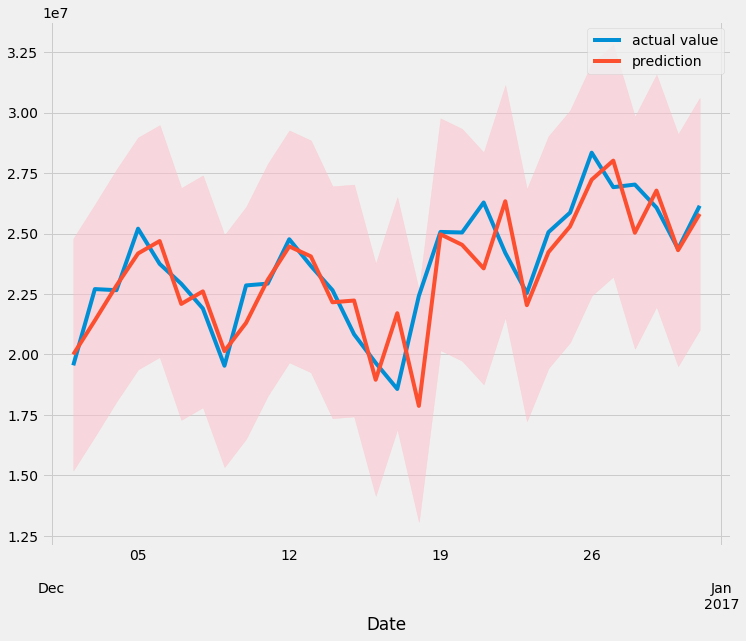

In [60]:
fig,ax=plt.subplots()
top_page_filtered[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
forecast_mean.plot(ax=ax,label='prediction')
plt.fill_between(confidence_interval.index, \
                confidence_interval['lower Views'], \
                confidence_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.legend()
plt.show()

## Forecasting

In [68]:
forecast_values = result.get_forecast(steps=30)
forecast_values_mean = forecast_values.predicted_mean
conf_interval = forecast_values.conf_int()

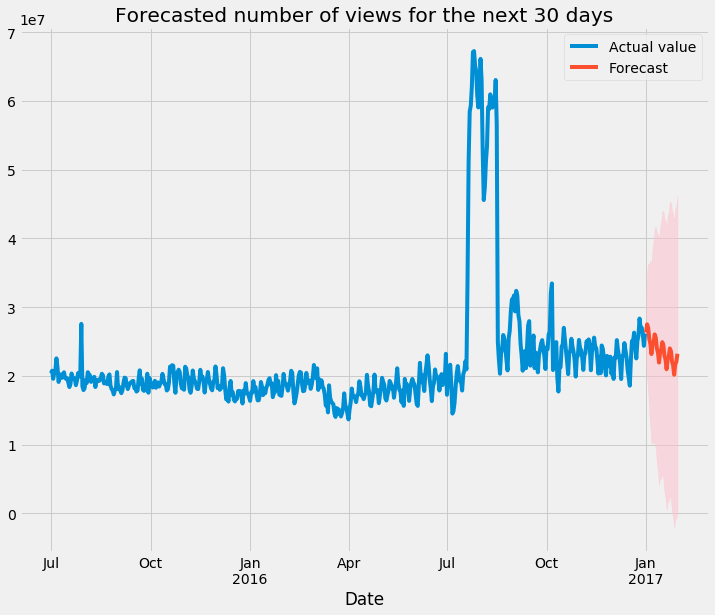

In [82]:
fig,ax=plt.subplots()
top_page_filtered.rename(columns={'Views':'Actual value'}).plot(ax=ax)
forecast_values_mean.plot(ax=ax,label='Forecast')
plt.fill_between(conf_interval.index, \
                conf_interval['lower Views'], \
                conf_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

## ARIMA model

In [72]:
arima_aic_bic = []
for p in range(7):
    for q in range(7):
        try:
            arima_model = SARIMAX(top_page_filtered, order=(p,1,q))
            arima_result = arima_model.fit()
            arima_aic_bic.append((p,q,arima_result.aic,arima_result.bic))
        except:
            continue

arima_aic_bic_df = pd.DataFrame(arima_aic_bic,columns=['p','q','aic','bic'])
print(arima_aic_bic_df.sort_values('aic'))

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq,

    p  q           aic           bic
39  6  5  17660.045547  17711.742728
29  4  5  17661.262258  17704.343242
35  5  6  17665.056374  17716.753555
23  3  4  17668.448222  17702.913010
38  6  2  17674.307754  17713.080640
33  5  4  17675.537861  17718.618845
30  4  6  17676.887852  17724.276934
24  3  5  17676.940191  17715.713077
18  2  5  17678.736500  17713.201287
28  4  4  17682.047597  17720.820483
34  5  5  17693.283841  17740.672924
15  2  2  17697.143265  17718.683757
40  6  6  17699.209987  17755.215267
17  2  4  17717.389008  17747.545697
37  6  1  17718.101582  17752.566370
13  1  6  17718.792532  17753.257319
25  3  6  17719.081355  17762.162340
19  2  6  17719.258346  17758.031232
6   0  6  17719.467484  17749.624173
12  1  5  17720.167898  17750.324587
9   1  2  17720.242033  17737.474427
11  1  4  17720.373204  17746.221795
3   0  3  17721.452148  17738.684542
32  5  1  17721.561525  17751.718214
27  4  1  17722.049423  17747.898013
20  3  0  17722.601392  17739.833786
1

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [77]:
arima_model = SARIMAX(top_page_filtered,order=(6,1,5))
arima_result = arima_model.fit()
arima_forecast_mean = arima_result.get_prediction(steps=-30).predicted_mean

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


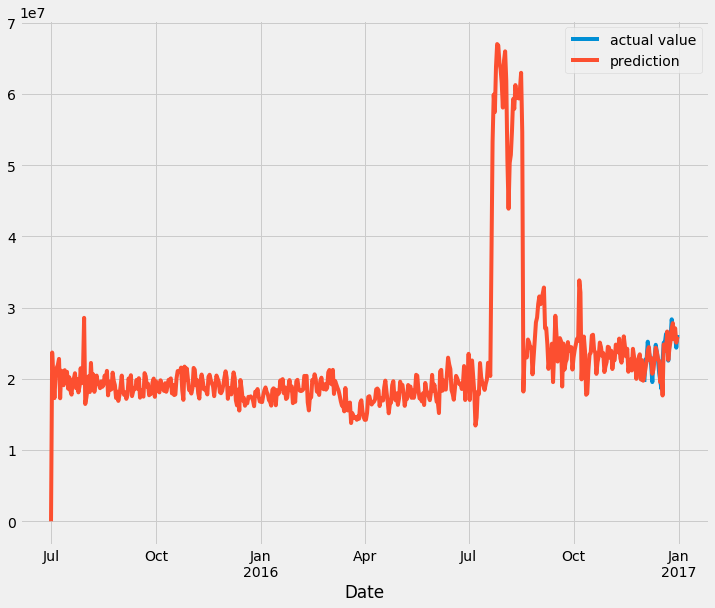

In [79]:
fig,ax=plt.subplots()
top_page_filtered[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
arima_forecast_mean.plot(ax=ax,label='prediction')
plt.legend()
plt.show()

In [80]:
arima_forecast_values = arima_result.get_forecast(steps=30)
arima_forecast_mean = arima_forecast_values.predicted_mean
arima_conf_interval = arima_forecast_values.conf_int()

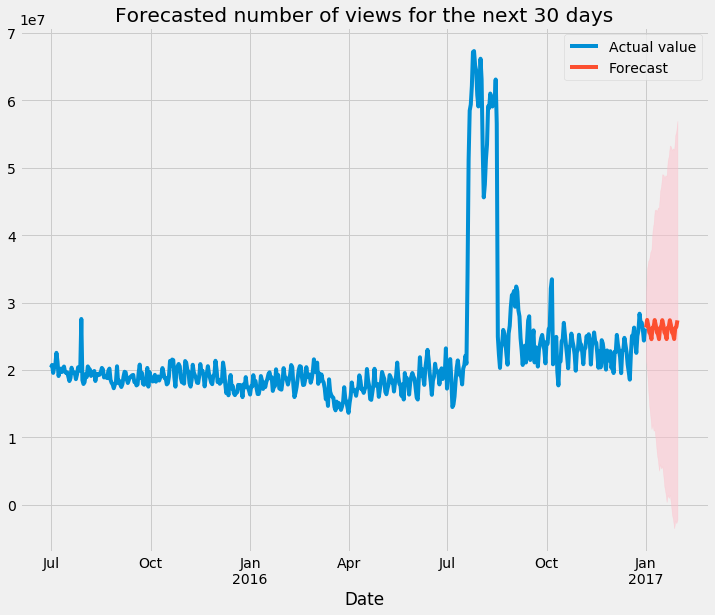

In [83]:
fig,ax=plt.subplots()
top_page_filtered.rename(columns={'Views':'Actual value'}).plot(ax=ax)
arima_forecast_mean.plot(ax=ax,label='Forecast')
plt.fill_between(arima_conf_interval.index, \
                arima_conf_interval['lower Views'], \
                arima_conf_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()